# Setup

In [ ]:
import numpy as np
import pylab as plt

from sklearn.datasets import make_moons, make_circles, fetch_openml

In [ ]:
# Vanilla PCA for comparison
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        X = np.array(X)
        N, D = X.shape
        self.mu_ = np.mean(X, axis=0)
        S = ((X-self.mu_).T @ (X-self.mu_)) / N
        self.lmbdas_, self.U_ = np.linalg.eigh(S)
        sort_idx = np.argsort(-self.lmbdas_)
        self.lmbdas_ = self.lmbdas_[sort_idx]
        self.U_ = self.U_[:, sort_idx]
        self._determine_M()
        return self

    def transform(self, X):
        B = self.U_[:, :self.M_]
        X = np.array(X)
        Z = (X-self.mu_) @ B
        return Z

    def inverse_transform(self, Z):
        B = self.U_[:, :self.M_]
        Z = np.array(Z)
        X = Z @ B.T
        X += self.mu_
        return X

    def _determine_M(self):
        if self.n_components >= 1:
            self.M_ = self.n_components
        elif 0 < self.n_components < 1:
            cum_lmbdas = np.cumsum(self.lmbdas_ / np.sum(self.lmbdas_))
            self.M_ = np.argmax(cum_lmbdas >= self.n_components) + 1
        else:
            raise ValueError('Invalid `n_components` parameter.')

# **Principal Component Analysis - Extensions**
In this notebook, we will implement two extensions to the *principal component analysis* (PCA) algorithm.
First, we will implement the high-dimensional data version, which takes care of the case where the number of samples $N$ is smaller than the number of features $D$. Subsquently, we will implement the kernel version which allows to obtain projected data of a PCA in an unknown feature space.

Mathematically, we denote an obtained data set consisting of $N$ samples as a matrix $\mathbf{X} \in \mathbb{R}^{N \times D}$, where the $n$-th row of this matrix represents the $n$-th samples being a $D$-dimensional feature vector: $\mathbf{x}_n = (x_{n1}, \dots, x_{nD})^\mathrm{T}$.

## **High-dimensional PCA**

In [ ]:
X_img_all, y_img_all = fetch_openml('mnist_784', version=1, return_X_y=True)
# convert from pandas to numpy if necessary

idx = np.random.choice(range(len(X_img_all)), replace=False, size=20)
X_img = X_img_all[idx]
y_img = y_img_all[idx]

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


KeyError: "None of [Index([10849, 50268,  5098,   141, 11185, 17843, 53449, 26377, 48501, 44784,\n       20075, 22096, 69760, 53080, 57050, 32908, 29894, 67217, 54637, 23317],\n      dtype='int64')] are in the [columns]"

> A corresponding class for high-dimensional PCA is to be implemented below.

In [ ]:
class HighDimPCA(PCA):
    """ This class implements the principal component analysis for N < D,
        where N is the number of samples and D is the number of features.
    """
    def fit(self, X):
        """
        Determine required parameters of the PCA.

        Args:
            X (array-like):  Input samples.

        Returns:
            The fitted PCA object.
        """
        # Transform to ndarray.
        X = np.array(X)
        N, D = X.shape


        # Compute mean of each feature dimension.
        self.mu_ = np.mean(X, axis=0)
        # Compute NxN covariance matrix.
        C = ((X-self.mu_) @ (X-self.mu_).T) / N
        # Compute eigenvalues and eigenvectors.
        deltas, V = np.linalg.eigh(C)

        # Compute eigenvalues of S.
        self.lmbdas_ = np.zeros(D)
        self.lmbdas_[:N] = deltas

        # Compute eigenvectors of S.
        self.U_ = np.zeros((D, D))
        self.U_[:, :N] = (X-self.mu_).T @ V

        # Normalize eigenvectors.
        self.U_[:, :N] /= np.linalg.norm(self.U_[:, :N], axis=0)

        # Sort eigenvalues and eigenvectors in decreasing order.
        sort_idx = np.argsort(-self.lmbdas_)
        self.lmbdas_ = self.lmbdas_[sort_idx]
        self.U_ = self.U_[:, sort_idx]

        self._determine_M()

        return self

> Compare its runtime against the vanilla PCA implementation (e.g., using `%timeit`)

In [ ]:
# Example for timeit
%timeit np.dot(5, 5)

The slowest run took 23.53 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.7 µs per loop


In [ ]:
%timeit PCA(n_components=2).fit(X_img).transform(X_img)
%timeit HighDimPCA(n_components=2).fit(X_img).transform(X_img)

10 loops, best of 5: 132 ms per loop
100 loops, best of 5: 3.95 ms per loop


## **Kernel PCA**

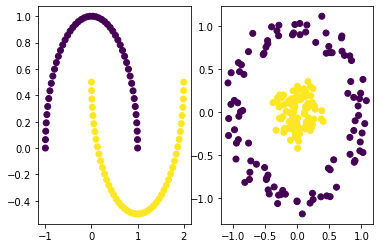

In [ ]:
X_moons, y_moons = make_moons(n_samples=100, random_state=0)
X_circles, y_circles = make_circles(n_samples=200, factor=.2, noise=.1)

plt.subplot(121)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)

plt.subplot(122)
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles)
plt.show()

> Implement a standard PCA algorithm using sklearn. Reduce the number of components and try to explain why standard PCA is not working here.

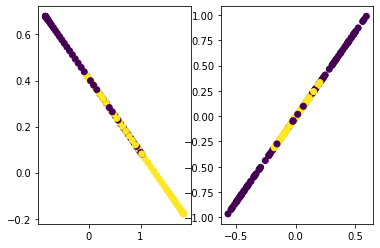

In [ ]:
pca = PCA(1)
Z_moons = pca.fit(X_moons).transform(X_moons)
X_pca = pca.inverse_transform(Z_moons)
plt.subplot(121)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_moons)

pca = PCA(1)
Z_circles = pca.fit(X_circles).transform(X_circles)
X_pca = pca.inverse_transform(Z_circles)
plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_circles)
plt.show()

# Standard PCA does not work because it is a linear projection in the feature space. So how about changing the feature space?

> Implement the Gaussian kernel given by: $$k_\sigma(\mathbf{x},\mathbf{x}^{\prime})=\exp(-\left\Vert \mathbf{x}-\mathbf{x}^{\prime}\right\Vert ^{2}/\sigma) $$

In [ ]:
class GaussianKernel:
    def __init__(self, sigma):
        self.sigma = sigma

    def __call__(self, x, y):
        x, y = np.array(x), np.array(y)
        return np.exp( - np.sum((x-y)**2) / self.sigma)

> A corresponding class for the KernelPCA is to be implemented below.

In [ ]:
class KernelPCA:
    """This class implements the kernel version of the principal component analysis.

    Args:
        n_comonents (int): Number of components to consider.

    """
    def __init__(self, n_components, kernel_func):
        self.n_components = n_components
        self.kernel_func = kernel_func

    def fit(self, X):
        """Determine required parameters of the Kernel PCA.

        Args:
            X (array-like): Input samples.

        Returns:
            The fitted PCA object.
        """
        self.X = np.array(X)

        # Compute the Kernel Matrix
        K = self.get_gram_matrix(self.X)
        K_tilde = self.center_gram_matrix(K)

        # Compute a_vec
        eigvals, eigvecs = np.linalg.eigh(K_tilde)
        self.a_ = eigvecs.T
        self.lmb_ = eigvals

        idx = np.argsort(eigvals)[::-1]
        self.a_ = self.a_[idx]
        self.lmb_ = self.lmb_[idx]
        return self

    def get_gram_matrix(self, X1, X2=None):
        """ Computes the gram marix.

        Args:
            X (ndarray): Samples in the input space.

        Returns
            The gram matrix for all samples.
        """
        if X2 is None:
            X2 = X1
        K = np.array([[self.kernel_func(x, y) for y in X2] for x in X1])
        return K

    def center_gram_matrix(self, K):
        """ Computes the gram matrix with centered features.

        Args:
            K (ndarray): Gram matrix computed by a kernel.

        Returns
            Transformed gram matrix with mean zero in the projection space.
        """
        N, M = K.shape
        I_N = np.ones((N, M))/N
        K_centered = K - 1/N*np.sum(K, axis=0) - 1/N*np.sum(K, axis=1, keepdims=True) + 1/(N**2)*np.sum(K)
        # Only works if K is square matrix
        # K_centered = K - I_N*K - K*I_N + I_N*K*I_N
        return K_centered

    def transform(self, X):
        """ Transforms samples from the D-dimensional input space into
            the M-dimensional projection space.

        Args:
            X (ndarray): Samples in the input space.

        Returns
            Transformed samples in the projection space.
        """
        K_mat = self.get_gram_matrix(X, self.X)
        K_mat_tilde = self.center_gram_matrix(K_mat)
        y = K_mat_tilde @ self.a_[:self.n_components].T
        return y

> Apply the Kernel PCA to the two-dimensional toy data sets and plot the features space projected on some principal components.

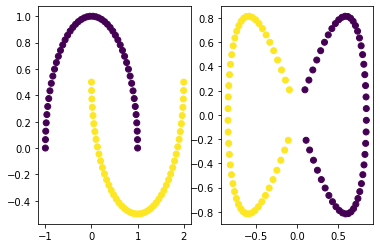

In [ ]:
kernel_pca = KernelPCA(2, GaussianKernel(.05))
kernel_pca.fit(X_moons)
X_transformed = kernel_pca.transform(X_moons)

plt.subplot(121)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)
plt.subplot(122)
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y_moons)
plt.show()

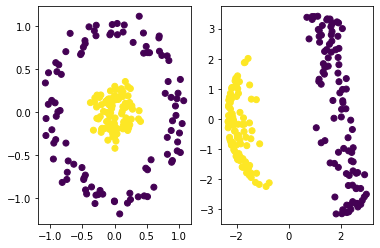

In [ ]:
np.random.seed(0)
kernel_pca = KernelPCA(2, GaussianKernel(.8))
kernel_pca.fit(X_circles)
X_transformed = kernel_pca.transform(X_circles)
plt.subplot(121)
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles)
plt.subplot(122)
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y_circles)
plt.show()